### Import modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

from pyod.models.ocsvm import OCSVM
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.xgbod import XGBOD

from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from utils import compute_scores, compute_roc_auc, train_model

D:\Anaconda\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### preprocessing

In [2]:
# data without attacks
data_dir = './data'
train_raw = pd.read_csv(os.path.join(data_dir,'dataset04.csv'), parse_dates=['DATETIME'], dayfirst=True)

sensor_cols = [col for col in train_raw.columns if col not in ['DATETIME','ATT_FLAG']]

# scale data
scaler = MinMaxScaler()
X_train = pd.DataFrame(index=train_raw.index, columns=sensor_cols, data=scaler.fit_transform(train_raw[sensor_cols]))
Y_train = train_raw.loc[:,'ATT_FLAG']
contamination = Y_train.sum() / Y_train.values.shape[0]

# # split
# X_train, X_val, _, _ = train_test_split(X,X,test_size=0.33, random_state=42)

X_train
contamination
Y_train.values.shape[0]
# Y_train.sum()

4177

### train models

In [6]:
# from_scratch = True
from_scratch = False
ocsvm = train_model(X_train.values, Y_train.values, contamination, 'ocsvm', from_scratch)
iforest = train_model(X_train.values, Y_train.values, contamination, 'iforest', from_scratch)
lof = train_model(X_train.values, Y_train.values, contamination, 'lof', from_scratch)
knn = train_model(X_train.values, Y_train.values, contamination, 'knn', from_scratch)
xgbod = train_model(X_train.values, Y_train.values, contamination, 'xgbod', from_scratch)

### evaluation

In [4]:
raw_test = pd.read_csv(os.path.join(data_dir,'test_dataset.csv'))

X_test = pd.DataFrame(index=raw_test.index, columns=sensor_cols, data=scaler.transform(raw_test[sensor_cols]))
Y_test = raw_test['ATT_FLAG']
results = pd.DataFrame(index = ['OCSVM','IFOREST','LOF'], columns = ['accuracy','f1_score','precision','recall'])

Y_hat = ocsvm.predict(X_test.values)
results.loc['OCSVM'] = compute_scores(Y_test.values, Y_hat)
Y_hat = iforest.predict(X_test.values)
results.loc['IFOREST'] = compute_scores(Y_test.values, Y_hat)
Y_hat = lof.predict(X_test.values)
results.loc['LOF'] = compute_scores(Y_test.values, Y_hat)
Y_hat = knn.predict(X_test.values)
results.loc['KNN'] = compute_scores(Y_test.values, Y_hat)
Y_hat = xgbod.predict(X_test.values)
results.loc['XGBOD'] = compute_scores(Y_test.values, Y_hat)

results


D:\Anaconda\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,accuracy,f1_score,precision,recall
OCSVM,0.791766,0.30622,0.436364,0.235872
IFOREST,0.764959,0.180301,0.28125,0.132678
LOF,0.828626,0.487106,0.584192,0.41769
KNN,0.824318,0.459499,0.573529,0.383292
XGBOD,0.858784,0.444444,0.951613,0.289926


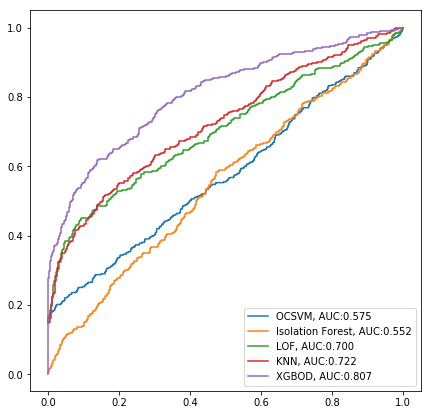

In [7]:
# visualize
models = [ocsvm, iforest, lof, knn, xgbod]
auc, fpr, tpr = [], [], []
for model in models:
    a,b,c = compute_roc_auc(Y_test.values, X_test.values, model)
    auc.append(a)
    fpr.append(b)
    tpr.append(c)

models_str = ['OCSVM', 'Isolation Forest', 'LOF', 'KNN', 'XGBOD']
f, ax = plt.subplots(1,figsize=(7,7))
for i in range(len(auc)):
    # print(fpr[i].shape)
    ax.plot(fpr[i], tpr[i], linestyle = None, label='{}, AUC:{:.3f}'.format(models_str[i], auc[i]))

ax.legend(fontsize=10)